In [1]:
%matplotlib inline

In [2]:
from load_um_sfh_data import load_mdpl2_data, load_bpl_data
halos, t_halos, z_halos = load_bpl_data()
print(halos.keys())

['a_first_infall', 'a_last_infall', 'halo_id', 'upid', 'sfr_history_all_prog', 'logmpeak', 'sfr_history_main_prog', 'sm_history_main_prog', 'log_mah', 'tmp', 'log_dmhdt', 'smh', 'log_ssfrh']


In [3]:
from sfh_fitting_script import T_TABLE, Z_TABLE, LOG_SSFR_CLIP
from diffmah.halo_assembly import _get_dt_array
DT_TABLE = _get_dt_array(T_TABLE)

In [4]:
from astropy.table import Table
import h5py
from sfh_fitting_script import DEFAULT_MAH_PARAMS, DEFAULT_SFR_PARAMS, DEFAULT_Q_PARAMS

fitting_keys = (
    'logmp', *DEFAULT_MAH_PARAMS.keys(), *DEFAULT_SFR_PARAMS.keys(), *DEFAULT_Q_PARAMS.keys())

fn = "DATA/test_bpl_fits.h5"
d = {}
with h5py.File(fn, 'r') as hdf:
    for key in fitting_keys:
        d['fit_'+key] = hdf[key][...]
    d['fit_halo_id'] = hdf['halo_id'][...]
    d['fit_loss'] = hdf['loss'][...]
t = Table(d)
t.keys()

['fit_logmp',
 'fit_dmhdt_x0',
 'fit_dmhdt_k',
 'fit_dmhdt_early_index',
 'fit_dmhdt_late_index',
 'fit_sfr_eff_m_0',
 'fit_sfr_eff_m_z',
 'fit_sfr_eff_beta_0',
 'fit_sfr_eff_beta_z',
 'fit_sfr_eff_gamma_0',
 'fit_sfr_eff_lgeps_n0',
 'fit_sfr_eff_lgeps_nz',
 'fit_qt',
 'fit_dq',
 'fit_halo_id',
 'fit_loss']

['fit_logmp', 'fit_dmhdt_x0', 'fit_dmhdt_k', 'fit_dmhdt_early_index', 'fit_dmhdt_late_index', 'fit_sfr_eff_m_0', 'fit_sfr_eff_m_z', 'fit_sfr_eff_beta_0', 'fit_sfr_eff_beta_z', 'fit_sfr_eff_gamma_0', 'fit_sfr_eff_lgeps_n0', 'fit_sfr_eff_lgeps_nz', 'fit_qt', 'fit_dq', 'fit_halo_id', 'fit_loss', 'a_first_infall', 'a_last_infall', 'upid', 'sfr_history_all_prog', 'logmpeak', 'sfr_history_main_prog', 'sm_history_main_prog', 'log_mah', 'tmp', 'log_dmhdt', 'smh', 'log_ssfrh']


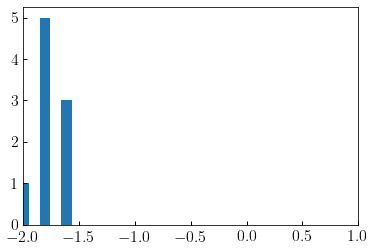

In [5]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(t['fit_halo_id'], halos['halo_id'])

for key in halos.keys():
    if key != 'halo_id':
        s = halos[key].shape
        if len(s) == 2:
            s = (len(t), s[1])
            t[key] = np.zeros(shape=s)
        else:
            t[key] = 0.
        t[key][idxA] = halos[key][idxB]
print(t.keys())

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-2, 1)
__=ax.hist(np.log10(t['fit_loss']))

In [6]:
_a = (None, None, None, None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

from fit_sfh import _predict_target_collection_kernel
f = jvmap(_predict_target_collection_kernel, in_axes=_a)

fitting_params = [t['fit_'+key].data for key in fitting_keys]
indx_tmp_fit = np.searchsorted(T_TABLE, t['tmp'])
args = (np.log10(T_TABLE), DT_TABLE, Z_TABLE, LOG_SSFR_CLIP, *fitting_params, indx_tmp_fit)
log_mah_pred, __, logsm_pred, log_ssfr_pred = f(*args)

/Users/aphearin/opt/miniconda3/envs/ht07/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


['fit_logmp', 'fit_dmhdt_x0', 'fit_dmhdt_k', 'fit_dmhdt_early_index', 'fit_dmhdt_late_index', 'fit_sfr_eff_m_0', 'fit_sfr_eff_m_z', 'fit_sfr_eff_beta_0', 'fit_sfr_eff_beta_z', 'fit_sfr_eff_gamma_0', 'fit_sfr_eff_lgeps_n0', 'fit_sfr_eff_lgeps_nz', 'fit_qt', 'fit_dq', 'fit_halo_id', 'fit_loss', 'a_first_infall', 'a_last_infall', 'upid', 'sfr_history_all_prog', 'logmpeak', 'sfr_history_main_prog', 'sm_history_main_prog', 'log_mah', 'tmp', 'log_dmhdt', 'smh', 'log_ssfrh']


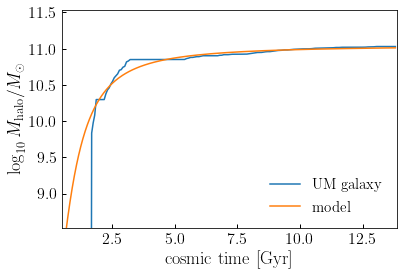

In [14]:
print(t.keys())

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.85)
itest = 7
_logmp = t['log_mah'][itest, -1]
__=ax.plot(t_halos, t['log_mah'][itest, :], label=r'${\rm UM \ galaxy}$')
__=ax.plot(T_TABLE, log_mah_pred[itest, :], label=r'${\rm model}$')

ylim = ax.set_ylim(_logmp-2.5, _logmp+0.5)

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\rm halo}/M_{\odot}$')

fig.savefig('logmah_fit_check.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)


/Users/aphearin/opt/miniconda3/envs/ht07/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


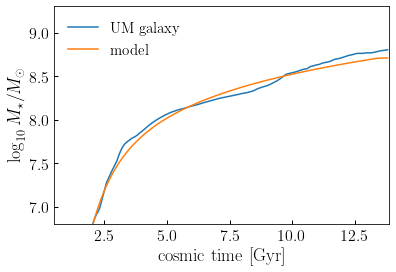

In [15]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.85)

_logsm = np.log10(t['smh'][itest, -1])
ylim = ax.set_ylim(_logsm-2, _logsm+0.5)

__=ax.plot(t_halos, np.log10(t['smh'][itest, :]), label=r'${\rm UM \ galaxy}$')
__=ax.plot(T_TABLE, logsm_pred[itest, :], label=r'${\rm model}$')

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}M_{\star}/M_{\odot}$')

fig.savefig('logsm_fit_check.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)


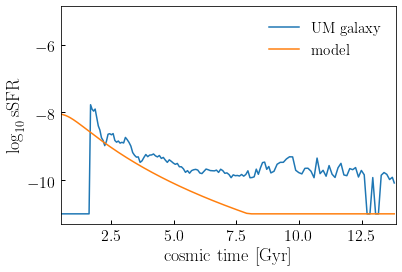

In [16]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.85)

__=ax.plot(t_halos, t['log_ssfrh'][itest, :], label=r'${\rm UM \ galaxy}$')
__=ax.plot(T_TABLE, log_ssfr_pred[itest, :], label=r'${\rm model}$')

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm sSFR}$')

fig.savefig('logssfr_fit_check.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)
